In [1]:
import numpy as np
import pandas as pd
import cv2
import re
from tqdm.notebook import tqdm
from PIL import Image
import hashlib
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop
import random
import tensorflow as tf

import os

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN_IMAGES = f'{DIR_INPUT}/train'

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape


(147793, 5)

In [3]:
train_df.sample(6)

image_id  width  height                        bbox     source
42757   c4dc3c575   1024    1024         [613, 599, 101, 65]  arvalis_1
81786   22c35fcbf   1024    1024    [0.0, 972.0, 35.0, 52.0]     ethz_1
107025  9bccf7e53   1024    1024  [645.0, 606.0, 99.0, 67.0]  arvalis_3
142616  5c6197826   1024    1024  [848.0, 961.0, 61.0, 63.0]     rres_1
113545  d145202eb   1024    1024  [105.0, 145.0, 64.0, 77.0]  arvalis_3
137053  6a7cbd408   1024    1024  [627.0, 713.0, 77.0, 79.0]     rres_1

In [4]:
train_df['image_id'].nunique()

3373

In [5]:
train_df.nunique()

image_id      3373
width            1
height           1
bbox        147761
source           7
dtype: int64

So, all the images we have are in same dimensions 1024x1024

In [6]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [7]:
train_df.groupby(by='image_id')['source'].count().agg(['min', 'max', 'mean'])

min       1.000000
max     116.000000
mean     43.816484
Name: source, dtype: float64

In [8]:
source = train_df['source'].value_counts()
source

ethz_1       51489
arvalis_1    45716
rres_1       20236
arvalis_3    16665
usask_1       5807
arvalis_2     4179
inrae_1       3701
Name: source, dtype: int64

In [9]:
fig = go.Figure(data=[
    go.Pie(labels=source.index, values=source.values)
])

fig.update_layout(title='Source distribution')
fig.show()

In [10]:
def show_images(image_ids):
    
    col = 5
    row = min(len(image_ids) // col, 5)
    
    fig, ax = plt.subplots(row, col, figsize=(16, 8))
    ax = ax.flatten()

    for i, image_id in enumerate(image_ids):
        image = cv2.imread(DIR_TRAIN_IMAGES + '/{}.jpg'.format(image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_axis_off()
        ax[i].imshow(image)
        
        
def show_image_bb(image_data):
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    image = cv2.imread(DIR_TRAIN_IMAGES + '/{}.jpg'.format(image_data.iloc[0]['image_id']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for i, row in image_data.iterrows():
        
        cv2.rectangle(image,
                      (int(row['x']), int(row['y'])),
                      (int(row['x']) + int(row['w']), int(row['y']) + int(row['h'])),
                      (220, 0, 0), 3)

    ax.set_axis_off()
    ax.imshow(image)
    

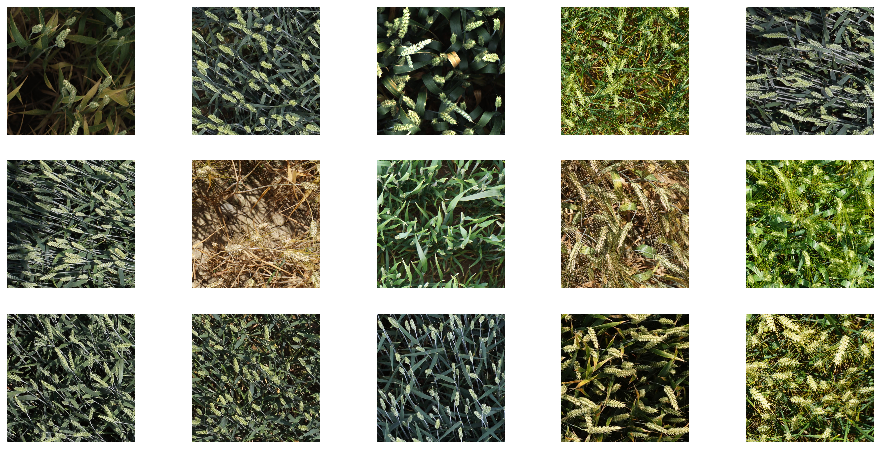

In [11]:
show_images(train_df.sample(n=15)['image_id'].values)

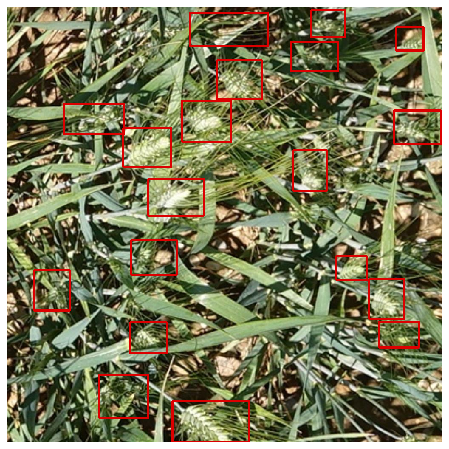

In [12]:
show_image_bb(train_df[train_df['image_id'] == '5e0747034'])

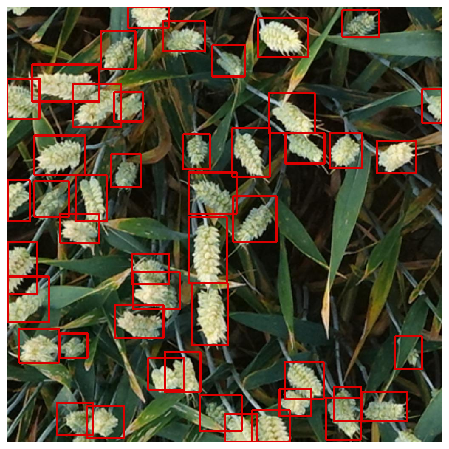

In [13]:
show_image_bb(train_df[train_df['image_id'] == '013fd7d80'])

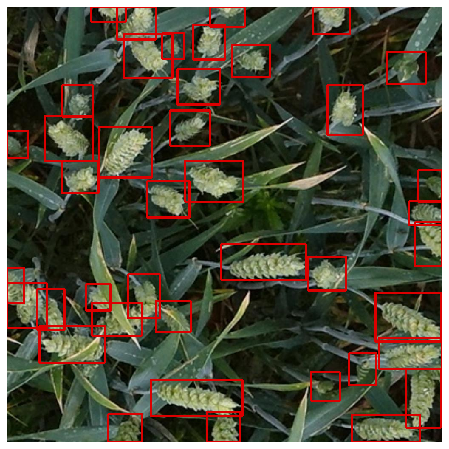

In [14]:
show_image_bb(train_df[train_df['image_id'] == '00764ad5d'])

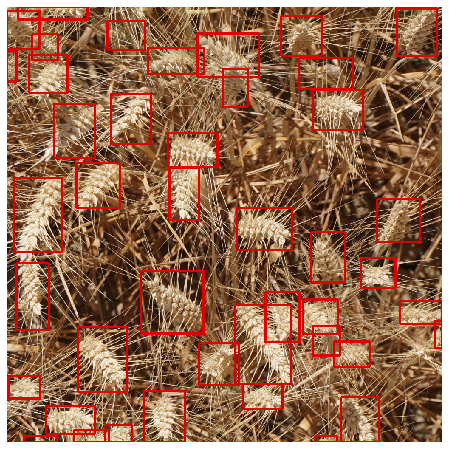

In [15]:
show_image_bb(train_df[train_df['image_id'] == '00e903abe'])

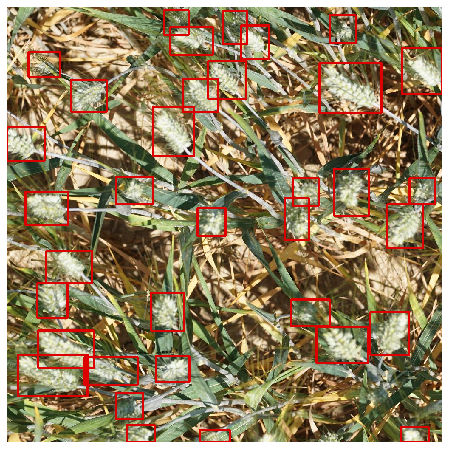

In [16]:
show_image_bb(train_df[train_df['image_id'] == '01189a3c3'])

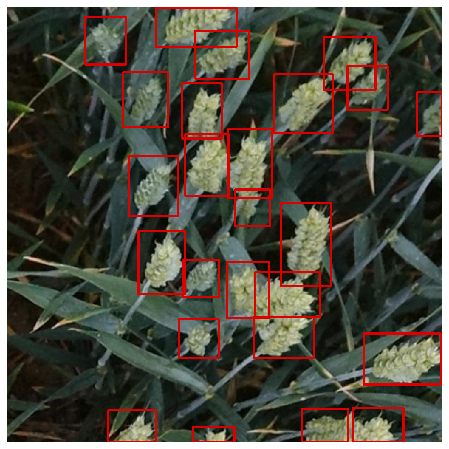

In [17]:
show_image_bb(train_df[train_df['image_id'] == '006a994f7'])